# Predicting ENSO
Here we are training a classifier to predict whether an El Nino or La Nina event is occuring. The input is a map of global SST, and the output is a classification of either 1=El Nino or 0=La Nino

In [1]:
# import packages, set random seed

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cartopy.crs as ccrs
import matplotlib as mpl

# set seeds
random_seed = 36
np.random.seed(random_seed)
tf.random.set_seed(int(random_seed))

#nice figures
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['font.size'] = 12

## Preprocessing
Load in the data from the netcdf. This is ERSSTv5 which has been deseasoned, linearly detrended, and has a 5 month lookback running mean applied. From this, we can calculate the Nino3.4 index.

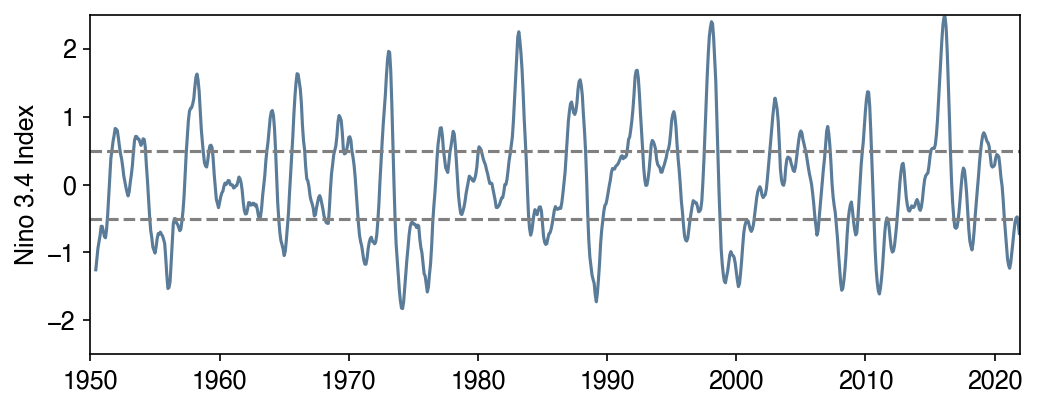

In [2]:
sststr = 'ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc'
sstds = xr.open_dataset(sststr)
sst = sstds.sst
time = sstds.time

ninolat1 = -5
ninolat2 = 5
ninolon1 = 190
ninolon2 = 240

sstnino = np.asarray(sst.sel(lat=slice(ninolat1,ninolat2),lon=slice(ninolon1,ninolon2)))
nino34 = np.nanmean(sstnino,axis=(1,2))
timevec = np.arange(1950+(5/12),2022,1/12)

plt.figure(figsize=(8,3))
plt.plot(timevec,nino34,color='xkcd:slate blue')
plt.hlines(0.5,1950,2022,linestyle='dashed',color='grey')
plt.hlines(-0.5,1950,2022,linestyle='dashed',color='grey')
plt.xlim(1950,2022)
plt.ylim(-2.5,2.5)
plt.ylabel("Nino 3.4 Index")
plt.show()

## Data preparation
First, we need to include only samples where nino event is occuring (i.e. nino3.4>0.5 or nino3.4<-0.5). Then, we will divide the sst input and nino3.4 output into training, validation and testing chunks.

In [3]:
nino_occur = nino34[(nino34>0.5) | (nino34<-0.5)] # only samples where nino event occurs
nino_occur[nino_occur>0.5] = 1 # make into categorical format, 1 for El Nino and 0 for La Nina
nino_occur[nino_occur<0.5] = 0
nino_occur = tf.keras.utils.to_categorical(nino_occur) # format accepted by NN
sizefull = nino_occur.shape[0]

train_val_test = [0.7,0.85,1] # set train/val/test fraction

sst = np.asarray(sst)
sizesst = sst.shape
sstnino_occur = sst[(nino34>0.5) | (nino34<-0.5),:,:] # grab sst samples where nino occurs
sstnino_occur = np.reshape(sstnino_occur,(sizefull,sizesst[1]*sizesst[2])) # reshape latxlon to vectors

trainind = range(int(train_val_test[0]*sizefull))
valind = range(int(train_val_test[0]*sizefull),int(train_val_test[1]*sizefull))
testind = range(int(train_val_test[1]*sizefull),int(train_val_test[2]*sizefull))

# divide into training/validation/testing
sst_train = sstnino_occur[trainind,:]
sst_val = sstnino_occur[valind,:]
sst_test = sstnino_occur[testind,:]

nino_train  = nino_occur[trainind]
nino_val = nino_occur[valind]
nino_test = nino_occur[testind]

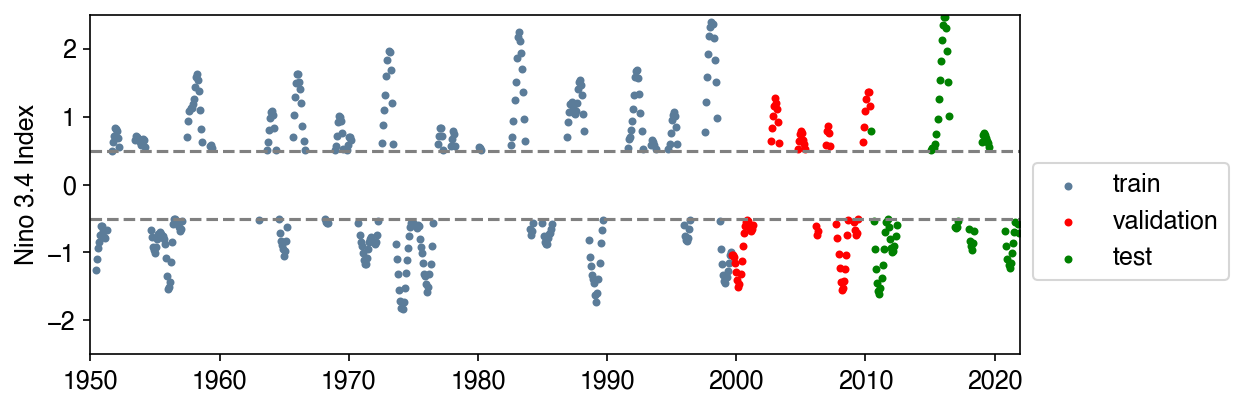

In [4]:
plt.figure(figsize=(8,3))
plt.scatter(timevec[(nino34>0.5) | (nino34<-0.5)][trainind],nino34[(nino34>0.5) | (nino34<-0.5)][trainind],color='xkcd:slate blue', s=8, label = "train")
plt.scatter(timevec[(nino34>0.5) | (nino34<-0.5)][valind],nino34[(nino34>0.5) | (nino34<-0.5)][valind],color='red', s=8, label = "validation")
plt.scatter(timevec[(nino34>0.5) | (nino34<-0.5)][testind],nino34[(nino34>0.5) | (nino34<-0.5)][testind],color='green', s=8, label = "test")
plt.hlines(0.5,1950,2022,linestyle='dashed',color='grey')
plt.hlines(-0.5,1950,2022,linestyle='dashed',color='grey')
plt.xlim(1950,2022)
plt.ylim(-2.5,2.5)
plt.ylabel("Nino 3.4 Index")
plt.legend(bbox_to_anchor=(1, 0.4, .1, 0.2))
plt.show()

Now we will standardize the sst anomaly values. For this, we use the standard deviation of each grid cell within the *training* set

In [5]:
sst_std = np.std(sst_train,axis=0) # standardized by the TRAINING STD

sst_train = np.divide(sst_train,sst_std)
sst_train[np.isnan(sst_train)] = 0 # set all nans to zeros (they are learned to be ignored)
sst_val = np.divide(sst_val,sst_std)
sst_val[np.isnan(sst_val)] = 0
sst_test = np.divide(sst_test,sst_std)
sst_test[np.isnan(sst_test)] = 0

## Neural Network

### Set some neural network parameters
Here we define parts of the neural network architecture and training parameters

In [6]:
# parameters to play with

hiddens = [12, 12] # hidden layers e.g. [10,20] means two hidden layers, 10 nodes connected to 20 nodes
ridgepen = 1 # L2/ridge penalty applied to input
lr = 1e-3 # learning rate
n_epochs = 20 # n training epochs
batch_size = 32 
activation = 'relu'
loss = 'categorical_crossentropy' 

2022-04-27 15:11:10.403550: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
11/11 - 0s - loss: 412.7692 - categorical_accuracy: 0.5710 - val_loss: 331.9941 - val_categorical_accuracy: 0.7143 - 391ms/epoch - 36ms/step
Epoch 2/20
11/11 - 0s - loss: 285.8634 - categorical_accuracy: 0.7623 - val_loss: 228.5787 - val_categorical_accuracy: 0.9000 - 30ms/epoch - 3ms/step
Epoch 3/20
11/11 - 0s - loss: 196.5210 - categorical_accuracy: 0.9012 - val_loss: 156.9861 - val_categorical_accuracy: 0.9714 - 32ms/epoch - 3ms/step
Epoch 4/20
11/11 - 0s - loss: 135.0403 - categorical_accuracy: 0.9753 - val_loss: 108.0543 - val_categorical_accuracy: 1.0000 - 30ms/epoch - 3ms/step
Epoch 5/20
11/11 - 0s - loss: 93.0638 - categorical_accuracy: 0.9969 - val_loss: 74.6824 - val_categorical_accuracy: 1.0000 - 31ms/epoch - 3ms/step
Epoch 6/20
11/11 - 0s - loss: 64.4065 - categorical_accuracy: 0.9938 - val_loss: 51.8440 - val_categorical_accuracy: 1.0000 - 32ms/epoch - 3ms/step
Epoch 7/20
11/11 - 0s - loss: 44.7733 - categorical_accuracy: 0.9938 - val_loss: 36.1527 - val_categor

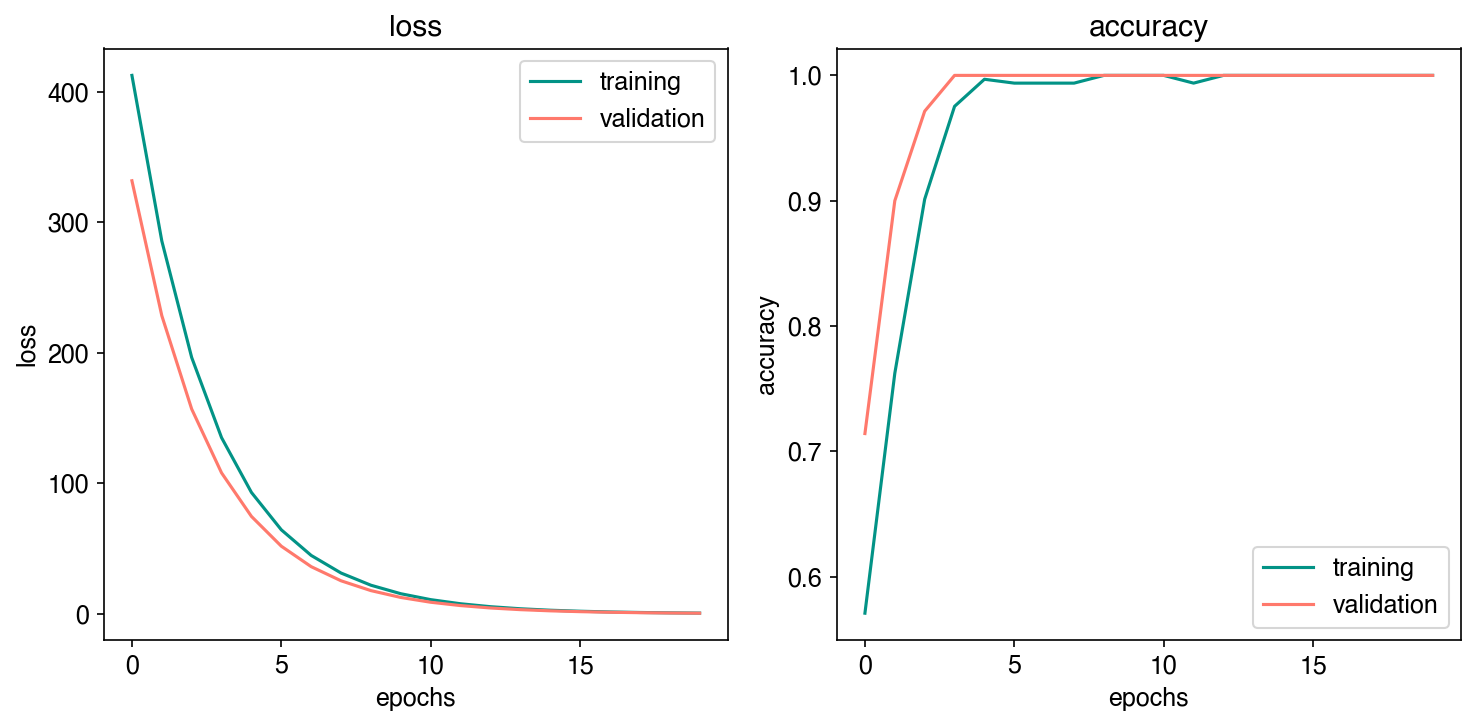

In [7]:
n_layers = len(hiddens)
output_nodes = 2

# define the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(hiddens[0], activation=activation,input_shape=(16020,),
            bias_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
            kernel_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
            kernel_regularizer=tf.keras.regularizers.L2(l2=ridgepen)))#,

# add hidden layers
for layer in range(1,n_layers):
    model.add(tf.keras.layers.Dense(hiddens[layer], activation=activation,
                    bias_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
                    kernel_initializer=tf.keras.initializers.RandomNormal(seed=random_seed)))

# final layer
model.add(tf.keras.layers.Dense(output_nodes,activation='softmax',
                bias_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
                kernel_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),))

# compile
model.compile(optimizer=tf.keras.optimizers.Adam(lr),  # optimizer
            loss=loss,   # loss function   
            metrics=[tf.keras.metrics.categorical_accuracy]) 

# train
history = model.fit(sst_train, nino_train, epochs=n_epochs, batch_size=batch_size, validation_data=(sst_val, nino_val), 
                    shuffle=True, verbose=2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],color='xkcd:teal',label='training')
plt.plot(history.history['val_loss'],color='xkcd:salmon',label='validation')
plt.xlabel("epochs"); plt.ylabel("loss")
plt.title("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'],color='xkcd:teal',label='training')
plt.plot(history.history['val_categorical_accuracy'],color='xkcd:salmon',label='validation')
plt.xlabel("epochs"); plt.ylabel("accuracy")
plt.title("accuracy")
plt.legend()

plt.tight_layout()


## Model evaluation
How does the model do on unseen data?

In [8]:
nino_pred = model.predict(sst_test) # make predictions for test data

nino_pred = np.argmax(nino_pred,axis=1)
nino_true = np.argmax(nino_test,axis=1)

modelcorr = nino_pred==nino_true
nmodelcorr = modelcorr[modelcorr].shape[0]
ntest = nino_true.shape[0]
print('Model accuracy on testing is %f%%' %(100*nmodelcorr/ntest))

Model accuracy on testing is 95.714286%


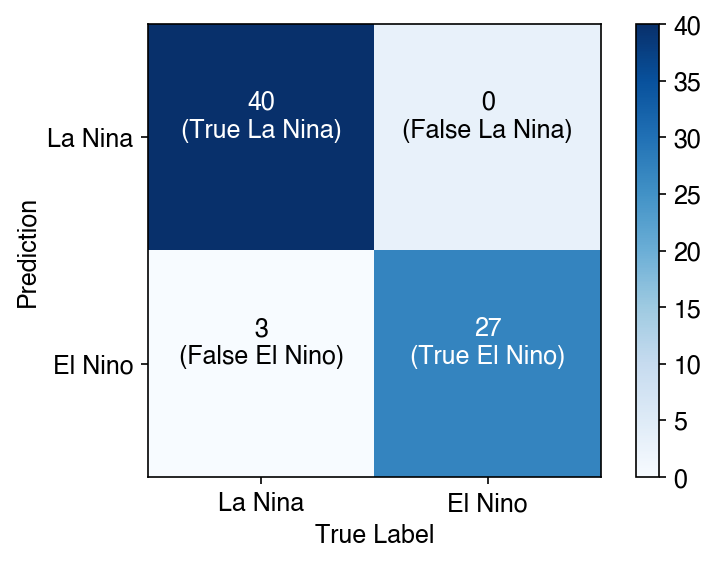

In [9]:
# confusion matrix

cm = tf.math.confusion_matrix(nino_true, nino_pred).numpy()
plt.imshow(cm, cmap = "Blues")
plt.text(x = 0, y = 0, s=str(cm[0,0]) + "\n(True La Nina)", color = "w", ha = "center")
plt.text(x = 0, y = 1, s=str(cm[0,1]) + "\n(False El Nino)", ha = "center")
plt.text(x = 1, y = 0, s=str(cm[1,0]) + "\n(False La Nina)", ha = "center")
plt.text(x = 1, y = 1, s=str(cm[1,1]) + "\n(True El Nino)", color = "w", ha = "center")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.colorbar()
plt.xticks((0,1), labels = ["La Nina", "El Nino"])
plt.yticks((0,1), labels = ["La Nina", "El Nino"]);

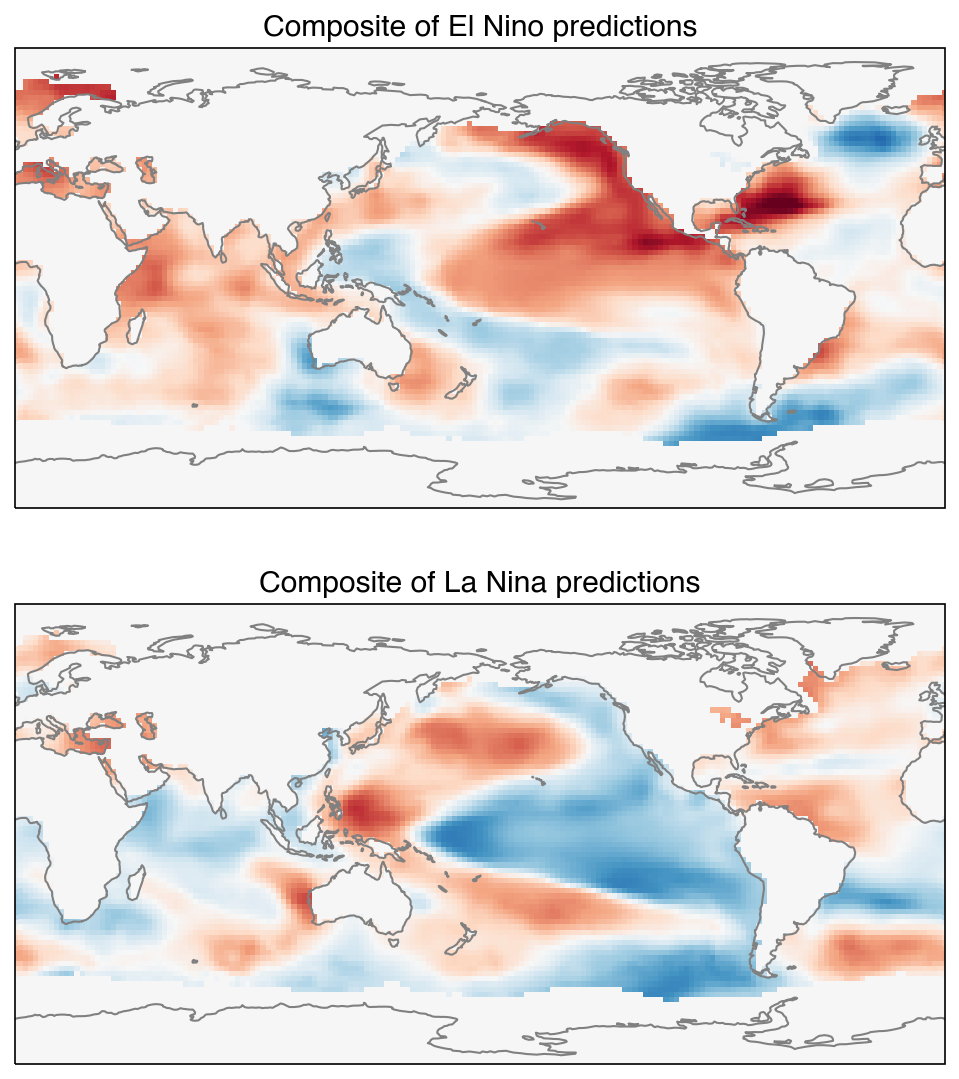

In [10]:
elninopred = (nino_pred==1)
laninapred = (nino_pred==0)

elnino_sst = sst_test[elninopred,:]
elnino_sst = np.reshape(elnino_sst,(elnino_sst.shape[0],sizesst[1],sizesst[2]))
lanina_sst = sst_test[laninapred,:]
lanina_sst = np.reshape(lanina_sst,(lanina_sst.shape[0],sizesst[1],sizesst[2]))

elninoplot = np.mean(elnino_sst,axis=0)
laninaplot = np.mean(lanina_sst,axis=0)

projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()
lat = np.asarray(sstds.lat)
lon = np.asarray(sstds.lon)

plt.figure(figsize=(8,9))

ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,elninoplot,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Composite of El Nino predictions')

ax2=plt.subplot(2,1,2,projection=projection)
ax2.pcolormesh(lon,lat,laninaplot,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax2.coastlines(color='gray')
plt.title('Composite of La Nina predictions')

plt.show()